In [1]:
## Step 1: Store 1 year of data for every necessary tag

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from ecotools.pi_client import pi_client
import requests
import seaborn as sns 
from sklearn.cluster import KMeans
import os
os.chdir(r"/Users/danielsoriano/Desktop/ds/kBtu Baselines")

import warnings
warnings.filterwarnings('ignore')
#print(mnv.version)  # Last updated for mnv v2.0.1
from dateutil.relativedelta import relativedelta
from matplotlib import style
style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split 
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.metrics import r2_score
import math
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor
#import auto_run_ele_tag
import logging
import ecotools.auto

In [6]:
import pandas as pd
import numpy as np
from ecotools.pi_client import pi_client
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
pc = pi_client(username= r'dbsorian')

def main():
    from datetime import datetime, timedelta
    #pred_start = pd.to_datetime(datetime.now().strftime('%Y-%m-%d %H:00:00')) - timedelta(days=1)
    #pred_end = datetime.now().strftime('%Y-%m-%d %H:00:00')
    pc = pi_client(username= r'dbsorian')

Connecting to PI API using 'basic authentication'


In [7]:
# Splits data into a training set
def split_data(X, y, test_size=0.2, shuffle=False, random_state=42):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=shuffle, random_state=random_state)
    return X_train, X_val, y_train, y_val

In [8]:
data_name = pc.search_by_point("*steam*demand_kBtu")

In [9]:
def data_manipu(data_name, df, temp):
    # get the data and rename columns
    df["Temp"] = temp
    df['cdd'] = 0
    df.loc[df.Temp > 65, 'cdd'] = df.loc[df.Temp > 65, 'Temp'] - 65
    df['hdd'] = 0
    df.loc[df.Temp < 65, 'hdd'] = 65 - df.loc[df.Temp < 65, 'Temp']
    df['cdd2'] = df.cdd**2
    df['hdd2'] = df.hdd**2
    df["Hour"] = df.index.hour
    df["Month"] = df.index.month
    df["DOW"] = df.index.dayofweek
    df['covid'] = 0
    df.loc["2020-03-17":"2021-09-28", 'covid'] = 1
    
    # specifiy the rolling std method
#     df = df.dropna()
#     r = df.rolling(window=20)  # Create a rolling object (no computation yet)
#     mps1 = r.mean() + 3 * r.std()  # Combine a mean and stdev on that object
#     mps2 = r.mean() - 3 * r.std()
#     mps3 = r.mean() + 3 * r.std()
#     mps4 = r.mean() - 3 * r.std()
    
#     # identify outliers
#     cc1=df[df[data_name] > mps1[data_name]]
#     cc2= df[df[data_name] < mps2[data_name]]
#     dd1=df[df.Temp > mps3.Temp]
#     dd2=df[df.Temp < mps4.Temp]

#     # remove outliers
#     index_names_1 = cc1.index_names_1 = cc1[data_name].index
#     index_names_2 = cc2.index_names_2 = cc2[data_name].index
#     index_names_3 = dd1.Temp.index
#     index_names_4 = dd2.Temp.index
#     final_index_name = index_names_1.union(index_names_2).union(index_names_3).union(index_names_4)
#     df.drop(final_index_name, inplace=True)
    
    x = df.loc[:, ['Temp','cdd','hdd','cdd2','hdd2','Hour','Month','DOW','covid']]
    y = df[data_name]
    
    # split the cleaned data
    X_train, X_val, y_train, y_val = split_data(x,y)
    
    return X_train, X_val, y_train, y_val

In [11]:
    # Pull out all electricity tags data and weather
tags = pc.search_by_point("*steam*demand_kBtu")
tags.append("aiTIT4045")

start = datetime.now() - timedelta(days=365)
end = datetime.now()
interval = '1h'    
calc = 'summary'  
chunk_size = 10

df = pc.get_stream_by_point(tags, start=start, end=end, 
                            _convert_cols='numeric', calculation=calc, 
                            interval=interval, _chunk_size=chunk_size)
df


11:53:27: Sending API request... Chunk 1 of 10
11:53:30: Response recieved for 10 tags! (3.08)
11:53:33: Sending API request... Chunk 2 of 10
11:53:37: Response recieved for 10 tags! (4.23)
11:53:39: Sending API request... Chunk 3 of 10
11:53:42: Response recieved for 10 tags! (2.74)
11:53:44: Sending API request... Chunk 4 of 10
11:53:47: Response recieved for 10 tags! (3.68)
11:53:50: Sending API request... Chunk 5 of 10
11:53:54: Response recieved for 10 tags! (3.9)
11:53:56: Sending API request... Chunk 6 of 10
11:54:01: Response recieved for 10 tags! (5.05)
11:54:03: Sending API request... Chunk 7 of 10
11:54:10: Response recieved for 10 tags! (6.82)
11:54:12: Sending API request... Chunk 8 of 10
11:54:17: Response recieved for 10 tags! (4.87)
11:54:19: Sending API request... Chunk 9 of 10
11:54:22: Response recieved for 10 tags! (3.49)
11:54:24: Sending API request... Chunk 10 of 10
11:54:28: Response recieved for 9 tags! (3.78)


,AcademicSurge_Steam_Demand_kBtu,Administrative_Support_Building_Steam_Demand_kBtu,ARCPavilion_Steam_Demand_kBtu,ARC_Steam_Demand_kBtu,Art_Music_Wright_Steam_Demand_kBtu,Asmundson_Annex_Steam_Demand_kBtu,Asmundson_Steam_Demand_kBtu,Bainer_Steam_Demand_kBtu,Briggs_Steam_Demand_kBtu,California_Steam_Demand_kBtu,...,VMSSAC_Steam_Demand_kBtu,VMTH_Steam_Demand_kBtu,Voorhies_Hall_Steam_Demand_kBtu,Walker_Hall_Steam_Demand_kBtu,WatershedResearch_Steam_Demand_kBtu,Wellman_Kerr_Steam_Demand_kBtu,WHNRC_Steam_Demand_kBtu,Wickson_Steam_Demand_kBtu,Young_Steam_Demand_kBtu,aiTIT4045
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-07-12 11:53:27.784051,65.910004,0.358949,43.602001,152.427073,192.660004,24.240313,95.101483,611.552846,1402.865685,3.736343,...,250.465000,1948.907959,98.306639,NaN,2.028000,1051.517944,26.583106,358.130938,655.923602,88.175837
2022-07-12 12:53:27.784051,65.910004,0.641051,43.602001,247.899720,192.660004,26.249067,45.124827,386.180716,1342.642700,3.370459,...,257.014850,1948.907959,99.463242,NaN,2.028000,1051.517944,17.763092,374.404692,595.941015,91.322093
2022-07-12 13:53:27.784051,65.910004,1.000000,43.602001,128.989351,192.660004,39.523537,56.914852,293.362862,1521.165243,2.990548,...,272.273261,1948.907959,81.100680,NaN,2.028000,1051.517944,11.347528,368.498838,452.555079,94.569157
2022-07-12 14:53:27.784051,65.910004,1.000000,43.602001,89.232002,192.660004,38.244403,66.798142,225.216256,1183.921711,2.452342,...,108.768437,1948.907959,98.953043,NaN,2.028000,1051.517944,12.202575,341.977303,617.836067,95.631093
2022-07-12 15:53:27.784051,65.910004,1.000000,44.584624,182.607251,192.660004,31.230748,95.173319,244.778419,1488.996433,2.028942,...,63.773080,1948.907959,90.841566,NaN,2.028000,1051.517944,27.494724,359.030304,630.031335,97.158130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-12 06:53:27.784051,213.953995,0.790517,140.404597,1243.038775,366.201068,0.000000,77.140140,638.738473,3432.038373,0.000000,...,307.944917,1948.907959,0.000000,0.000000,117.624001,1051.517944,770.726234,361.705031,752.608771,66.085730
2023-07-12 07:53:27.784051,213.953995,0.790517,216.886062,621.959593,416.528388,0.000000,44.413068,246.552091,2394.929512,0.000000,...,260.021844,1948.907959,0.000000,131.710618,117.624001,1051.517944,673.904622,392.842660,830.062515,70.033672
2023-07-12 08:53:27.784051,213.953995,0.790517,140.303742,654.939488,274.466254,0.000000,54.181172,302.648151,1979.966719,0.000000,...,151.865524,1948.907959,0.000000,35.654304,117.624001,1051.517944,672.457503,362.503669,800.452385,74.725274


In [12]:
# Drop all NaN columns
df2 = df.dropna(axis=1,how='all')
df2 = df2.ffill()
data2_name = df2.iloc[:,:-1].columns
data2_name
df2

,AcademicSurge_Steam_Demand_kBtu,Administrative_Support_Building_Steam_Demand_kBtu,ARCPavilion_Steam_Demand_kBtu,ARC_Steam_Demand_kBtu,Art_Music_Wright_Steam_Demand_kBtu,Asmundson_Annex_Steam_Demand_kBtu,Asmundson_Steam_Demand_kBtu,Bainer_Steam_Demand_kBtu,Briggs_Steam_Demand_kBtu,California_Steam_Demand_kBtu,...,VMSSAC_Steam_Demand_kBtu,VMTH_Steam_Demand_kBtu,Voorhies_Hall_Steam_Demand_kBtu,Walker_Hall_Steam_Demand_kBtu,WatershedResearch_Steam_Demand_kBtu,Wellman_Kerr_Steam_Demand_kBtu,WHNRC_Steam_Demand_kBtu,Wickson_Steam_Demand_kBtu,Young_Steam_Demand_kBtu,aiTIT4045
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-07-12 11:53:27.784051,65.910004,0.358949,43.602001,152.427073,192.660004,24.240313,95.101483,611.552846,1402.865685,3.736343,...,250.465000,1948.907959,98.306639,NaN,2.028000,1051.517944,26.583106,358.130938,655.923602,88.175837
2022-07-12 12:53:27.784051,65.910004,0.641051,43.602001,247.899720,192.660004,26.249067,45.124827,386.180716,1342.642700,3.370459,...,257.014850,1948.907959,99.463242,NaN,2.028000,1051.517944,17.763092,374.404692,595.941015,91.322093
2022-07-12 13:53:27.784051,65.910004,1.000000,43.602001,128.989351,192.660004,39.523537,56.914852,293.362862,1521.165243,2.990548,...,272.273261,1948.907959,81.100680,NaN,2.028000,1051.517944,11.347528,368.498838,452.555079,94.569157
2022-07-12 14:53:27.784051,65.910004,1.000000,43.602001,89.232002,192.660004,38.244403,66.798142,225.216256,1183.921711,2.452342,...,108.768437,1948.907959,98.953043,NaN,2.028000,1051.517944,12.202575,341.977303,617.836067,95.631093
2022-07-12 15:53:27.784051,65.910004,1.000000,44.584624,182.607251,192.660004,31.230748,95.173319,244.778419,1488.996433,2.028942,...,63.773080,1948.907959,90.841566,NaN,2.028000,1051.517944,27.494724,359.030304,630.031335,97.158130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-12 06:53:27.784051,213.953995,0.790517,140.404597,1243.038775,366.201068,0.000000,77.140140,638.738473,3432.038373,0.000000,...,307.944917,1948.907959,0.000000,0.000000,117.624001,1051.517944,770.726234,361.705031,752.608771,66.085730
2023-07-12 07:53:27.784051,213.953995,0.790517,216.886062,621.959593,416.528388,0.000000,44.413068,246.552091,2394.929512,0.000000,...,260.021844,1948.907959,0.000000,131.710618,117.624001,1051.517944,673.904622,392.842660,830.062515,70.033672
2023-07-12 08:53:27.784051,213.953995,0.790517,140.303742,654.939488,274.466254,0.000000,54.181172,302.648151,1979.966719,0.000000,...,151.865524,1948.907959,0.000000,35.654304,117.624001,1051.517944,672.457503,362.503669,800.452385,74.725274


In [13]:
for i in range(df2.shape[1]):
    df = df2
    temp = df.aiTIT4045

    df["Temp"] = temp
    df['cdd'] = 0
    df.loc[df.Temp > 65, 'cdd'] = df.loc[df.Temp > 65, 'Temp'] - 65
    df['hdd'] = 0
    df.loc[df.Temp < 65, 'hdd'] = 65 - df.loc[df.Temp < 65, 'Temp']
    df['cdd2'] = df.cdd**2
    df['hdd2'] = df.hdd**2
    df["Hour"] = df.index.hour
    df["Month"] = df.index.month
    df["DOW"] = df.index.dayofweek
    df['covid'] = 0
    df.loc["2020-03-17":"2021-09-28", 'covid'] = 1

        # specifiy the rolling std method
#     df = df.dropna()
#     r = df2.rolling(window=20)  # Create a rolling object (no computation yet)
#     mps1 = r.mean() + 3 * r.std()  # Combine a mean and stdev on that object
#     mps2 = r.mean() - 3 * r.std()
#     mps3 = r.mean() + 3 * r.std()
#     mps4 = r.mean() - 3 * r.std()

        # identify outliers
#     cc1=df2[df2[data2_name[i]] > mps1[data2_name[i]]]
#     cc2= df2[df2[data2_name[i]] < mps2[data2_name[i]]]
#     dd1=df2[df2.Temp > mps3.Temp]
#     dd2=df2[df2.Temp < mps4.Temp]

#         # remove outliers
#     index_names_1 = cc1.index_names_1 = cc1[data2_name[i]].index
#     index_names_2 = cc2.index_names_2 = cc2[data2_name[i]].index
#     index_names_3 = dd1.Temp.index
#     index_names_4 = dd2.Temp.index
#     final_index_name = index_names_1.union(index_names_2).union(index_names_3).union(index_names_4)
#     df.drop(final_index_name, inplace=True)

    x = df.loc[:, ['Temp','cdd','hdd','cdd2','hdd2','Hour','Month','DOW','covid']]
    y = df[data2_name]

        # split the cleaned data
    X_train, X_val, y_train, y_val = split_data(x,y)
# print(X_train)
# print(X_val)
# print(y_train)
# print(y_val)

In [14]:
    # scale the trained data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
df2

,AcademicSurge_Steam_Demand_kBtu,Administrative_Support_Building_Steam_Demand_kBtu,ARCPavilion_Steam_Demand_kBtu,ARC_Steam_Demand_kBtu,Art_Music_Wright_Steam_Demand_kBtu,Asmundson_Annex_Steam_Demand_kBtu,Asmundson_Steam_Demand_kBtu,Bainer_Steam_Demand_kBtu,Briggs_Steam_Demand_kBtu,California_Steam_Demand_kBtu,...,aiTIT4045,Temp,cdd,hdd,cdd2,hdd2,Hour,Month,DOW,covid
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-07-12 11:53:27.784051,65.910004,0.358949,43.602001,152.427073,192.660004,24.240313,95.101483,611.552846,1402.865685,3.736343,...,88.175837,88.175837,23.175837,0.0,537.119441,0.0,11,7,1,0
2022-07-12 12:53:27.784051,65.910004,0.641051,43.602001,247.899720,192.660004,26.249067,45.124827,386.180716,1342.642700,3.370459,...,91.322093,91.322093,26.322093,0.0,692.852587,0.0,12,7,1,0
2022-07-12 13:53:27.784051,65.910004,1.000000,43.602001,128.989351,192.660004,39.523537,56.914852,293.362862,1521.165243,2.990548,...,94.569157,94.569157,29.569157,0.0,874.335020,0.0,13,7,1,0
2022-07-12 14:53:27.784051,65.910004,1.000000,43.602001,89.232002,192.660004,38.244403,66.798142,225.216256,1183.921711,2.452342,...,95.631093,95.631093,30.631093,0.0,938.263837,0.0,14,7,1,0
2022-07-12 15:53:27.784051,65.910004,1.000000,44.584624,182.607251,192.660004,31.230748,95.173319,244.778419,1488.996433,2.028942,...,97.158130,97.158130,32.158130,0.0,1034.145326,0.0,15,7,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-12 06:53:27.784051,213.953995,0.790517,140.404597,1243.038775,366.201068,0.000000,77.140140,638.738473,3432.038373,0.000000,...,66.085730,66.085730,1.085730,0.0,1.178810,0.0,6,7,2,0
2023-07-12 07:53:27.784051,213.953995,0.790517,216.886062,621.959593,416.528388,0.000000,44.413068,246.552091,2394.929512,0.000000,...,70.033672,70.033672,5.033672,0.0,25.337851,0.0,7,7,2,0
2023-07-12 08:53:27.784051,213.953995,0.790517,140.303742,654.939488,274.466254,0.000000,54.181172,302.648151,1979.966719,0.000000,...,74.725274,74.725274,9.725274,0.0,94.580960,0.0,8,7,2,0


In [35]:
# test = df2.loc[:,["Month", "aiTIT4045", "Temp", "cdd", "hdd", "cdd2", "hdd2", "DOW"]]
# test.iloc[-670:-650, :]
# test.iloc[-30:-10, :]

,Month,aiTIT4045,Temp,cdd,hdd,cdd2,hdd2,DOW
Timestamp,,,,,,,,
2023-07-11 03:10:24.643637,7,62.423647,62.423647,0.000000,2.576353,0.000000,6.637594,1
2023-07-11 04:10:24.643637,7,61.846889,61.846889,0.000000,3.153111,0.000000,9.942109,1
2023-07-11 05:10:24.643637,7,61.024676,61.024676,0.000000,3.975324,0.000000,15.803205,1
2023-07-11 06:10:24.643637,7,64.141081,64.141081,0.000000,0.858919,0.000000,0.737742,1
2023-07-11 07:10:24.643637,7,65.960735,65.960735,0.960735,0.000000,0.923011,0.000000,1
2023-07-11 08:10:24.643637,7,69.826958,69.826958,4.826958,0.000000,23.299523,0.000000,1
2023-07-11 09:10:24.643637,7,74.020509,74.020509,9.020509,0.000000,81.369587,0.000000,1
2023-07-11 10:10:24.643637,7,78.604322,78.604322,13.604322,0.000000,185.077583,0.000000,1
2023-07-11 11:10:24.643637,7,83.284160,83.284160,18.284160,0.000000,334.310521,0.000000,1


In [36]:
# test.iloc[-8741:-8721,:]

,Month,aiTIT4045,Temp,cdd,hdd,cdd2,hdd2,DOW
Timestamp,,,,,,,,
2022-07-13 03:10:24.643637,7,65.587453,65.587453,0.587453,0.000000,0.345101,0.000000,2
2022-07-13 04:10:24.643637,7,64.496397,64.496397,0.000000,0.503603,0.000000,0.253616,2
2022-07-13 05:10:24.643637,7,63.513588,63.513588,0.000000,1.486412,0.000000,2.209422,2
2022-07-13 06:10:24.643637,7,64.888249,64.888249,0.000000,0.111751,0.000000,0.012488,2
2022-07-13 07:10:24.643637,7,68.470972,68.470972,3.470972,0.000000,12.047647,0.000000,2
2022-07-13 08:10:24.643637,7,71.906204,71.906204,6.906204,0.000000,47.695654,0.000000,2
2022-07-13 09:10:24.643637,7,74.958640,74.958640,9.958640,0.000000,99.174505,0.000000,2
2022-07-13 10:10:24.643637,7,77.622231,77.622231,12.622231,0.000000,159.320724,0.000000,2
2022-07-13 11:10:24.643637,7,80.629249,80.629249,15.629249,0.000000,244.273420,0.000000,2


In [15]:
def plotplot2(method, X_train, X_val, y_train, y_val):
    
    # set up stats calculation
    r2_train = r2_score(y_train, method.predict(X_train))
    r2_val = r2_score(y_val, method.predict(X_val))
    rmse_train = math.sqrt(mean_squared_error(y_train, method.predict(X_train)))
    rmse_val = math.sqrt(mean_squared_error(y_val, method.predict(X_val)))
    mae_train = np.median((method.predict(X_train) - y_train.values))
    mae_val = np.median(method.predict(X_val) - y_val.values)
    cvrmse_train = rmse_train/(np.max(method.predict(X_train))-np.min(method.predict(X_train))/2)
    cvrmse_val = rmse_val/(np.max(method.predict(X_val))-np.min((method.predict(X_val))/2))
    return cvrmse_val, r2_val


In [18]:
newdf = pd.DataFrame()
temperature = pd.DataFrame(df2.aiTIT4045)

# create a prediction for all tags to put in newdf
for i in range(len(df2.iloc[:,:-10].columns)):
#for i in range(15):

    X_train, X_val, y_train, y_val = data_manipu(df2.iloc[:,i].name, df2, temperature)
            # scale the data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    gbt = RandomForestRegressor(random_state=42)
    gbt_param_list = {"max_depth":[5,10],
                      "n_estimators":[100,1000]
                     }
            #using gradient boosting method
    gs_gbt = HalvingRandomSearchCV(gbt, gbt_param_list,cv = 3, factor=3, min_resources='smallest')
    gs_gbt.fit(X_train_scaled, y_train)
            # validation cvrmse > 0.3and r2 <0.6 check, if not, not run the rest and put the tag name into the list
    cvrmse_val, r2_val = plotplot2(method = gs_gbt,X_train = X_train_scaled, X_val = X_val_scaled,
                                   y_train = y_train, y_val= y_val)
            # print() 
            # print(round(cvrmse_val,2), round(r2_val,2))
            # print()

    start = datetime.now() - timedelta(days=365)
    end = datetime.now()
    x_predict = pc.get_stream_by_point('aiTIT4045',  start = start,
                                       end = end, calculation=calc,
                                       interval=interval,
                                       _chunk_size=chunk_size)
    x_predict.rename(columns = {'aiTIT4045':'Temp'}, inplace=True)
    x_predict['cdd'] = 0
    x_predict.loc[x_predict.Temp > 65, 'cdd'] = x_predict.loc[x_predict.Temp > 65, 'Temp'] - 65
    x_predict['hdd'] = 0
    x_predict.loc[x_predict.Temp < 65, 'hdd'] = 65 - x_predict.loc[x_predict.Temp < 65, 'Temp']
    x_predict['cdd2'] = x_predict.cdd**2
    x_predict['hdd2'] = x_predict.hdd**2
    x_predict["Hour"] = x_predict.index.hour
    x_predict["Month"] = x_predict.index.month
    x_predict["DOW"] = x_predict.index.dayofweek
    x_predict['covid'] = 0
            # x_predict.loc["2020-03-17":"2021-09-28", 'covid'] = 1
    x_predict = x_predict.dropna()
    x_predict_scaled = scaler.transform(x_predict)

            # final check
        #     df_check = pc.get_stream_by_point(data_name, start=pred_start, 
        #                                            end=pred_end, calculation=calculation,
        #                                            interval=interval, 
        #                                           _chunk_size=chunk_size)

        #     # checking cvrmse and r2
    if cvrmse_val > 0.5:
        pred = np.nan
        newdf.insert(i, data2_name[i], pred)
        print(i+1, "out of", len(df2.iloc[:,:-10].columns))
        #print(pd.DataFrame(pred, index=x_predict.index, columns = [data_name[i]]))

    else:
        # put new predicted values in newdf
        pred = gs_gbt.predict(x_predict_scaled)
        newdf.insert(i, data2_name[i], pred)
        print(i+1, "out of", len(df2.iloc[:,:-10].columns))
        #print(pd.DataFrame(pred, index=x_predict.index, columns = [data_name[i]]))

11:59:14: Sending API request... Chunk 1 of 1
11:59:15: Response recieved for 1 tags! (0.67)
1 out of 96
11:59:24: Sending API request... Chunk 1 of 1
11:59:24: Response recieved for 1 tags! (0.33)
2 out of 96
11:59:32: Sending API request... Chunk 1 of 1
11:59:33: Response recieved for 1 tags! (0.41)
3 out of 96
11:59:50: Sending API request... Chunk 1 of 1
11:59:51: Response recieved for 1 tags! (0.47)
4 out of 96
11:59:59: Sending API request... Chunk 1 of 1
11:59:59: Response recieved for 1 tags! (0.56)
5 out of 96
12:00:07: Sending API request... Chunk 1 of 1
12:00:07: Response recieved for 1 tags! (0.41)
6 out of 96
12:00:28: Sending API request... Chunk 1 of 1
12:00:30: Response recieved for 1 tags! (1.3)
7 out of 96
12:00:51: Sending API request... Chunk 1 of 1
12:00:52: Response recieved for 1 tags! (0.38)
8 out of 96
12:01:00: Sending API request... Chunk 1 of 1
12:01:01: Response recieved for 1 tags! (0.43)
9 out of 96
12:01:22: Sending API request... Chunk 1 of 1
12:01:22: 

In [19]:
newdf

,AcademicSurge_Steam_Demand_kBtu,Administrative_Support_Building_Steam_Demand_kBtu,ARCPavilion_Steam_Demand_kBtu,ARC_Steam_Demand_kBtu,Art_Music_Wright_Steam_Demand_kBtu,Asmundson_Annex_Steam_Demand_kBtu,Asmundson_Steam_Demand_kBtu,Bainer_Steam_Demand_kBtu,Briggs_Steam_Demand_kBtu,California_Steam_Demand_kBtu,CCAH_Steam_Demand_kBtu,Central_Cage_Wash_Steam_Demand_kBtu,Chemistry.Annex_Steam_Demand_kBtu,Chemistry_Steam_Demand_kBtu,Cole.B_Steam_Demand_kBtu
0,33.741504,0.911625,48.363319,43.764530,NaN,42.495916,71.236285,509.013439,1508.814147,3.531187,209.796105,570.751161,NaN,344.836757,305.350548
1,34.108294,0.954055,46.294763,56.023973,NaN,41.866554,67.698012,244.899815,1514.004128,3.406074,190.271247,303.177903,NaN,346.653134,294.754657
2,34.555091,1.000000,45.919245,50.306766,NaN,42.386597,67.432044,233.711996,1496.629842,3.204548,343.071853,85.289460,NaN,337.912499,284.082722
3,35.196500,1.000000,44.845265,47.550947,NaN,43.465153,68.568453,236.326572,1501.369662,2.956871,950.830930,74.398306,NaN,335.444004,283.759604
4,35.362702,1.000000,46.272948,54.417609,NaN,49.486131,70.026567,244.419035,1497.574807,2.722591,161.009537,20.346759,NaN,350.162963,282.347783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8725,37.301647,1.000000,260.027733,669.678391,NaN,86.500907,106.202278,787.791414,1599.225886,5.246147,418.361326,613.055226,NaN,589.587027,519.603055
8726,38.926634,1.000000,182.252967,442.140080,NaN,64.413723,81.637399,628.994860,1438.371868,7.196743,393.470138,538.213602,NaN,397.832229,525.691830
8727,39.883187,1.000000,137.781342,241.083068,NaN,45.818231,78.469763,596.424451,1550.956413,6.679091,374.654382,652.916793,NaN,354.014034,606.443404
8728,39.988560,1.000000,81.782680,115.553760,NaN,46.051183,75.541915,595.965276,1521.985059,5.734799,308.839941,363.666683,NaN,308.078052,607.095383


In [20]:
    # replace name for the new models
send_df = newdf.copy()
send_df.columns = send_df.columns.str.replace('Steam_Demand_kBtu','Baseline_Modeled_Steam')
send_df


# chunk_split = 24
# chunk = int(len(send_df)/chunk_split)

# i = 0
# while i < chunk_split:
#     pc.write_data_to_pi(send_df.iloc[chunk*i:chunk*(i+1), :], update_option='Replace', override='pinkdinosaur')
#     i += 1
    
#if __name__ == "__main__":
#    ecotools.auto.run_task(main, log_name='kbtu_model_ele', recipients=['dsimperiale@ucdavis.edu'])

,AcademicSurge_Baseline_Modeled_Steam,Administrative_Support_Building_Baseline_Modeled_Steam,ARCPavilion_Baseline_Modeled_Steam,ARC_Baseline_Modeled_Steam,Art_Music_Wright_Baseline_Modeled_Steam,Asmundson_Annex_Baseline_Modeled_Steam,Asmundson_Baseline_Modeled_Steam,Bainer_Baseline_Modeled_Steam,Briggs_Baseline_Modeled_Steam,California_Baseline_Modeled_Steam,CCAH_Baseline_Modeled_Steam,Central_Cage_Wash_Baseline_Modeled_Steam,Chemistry.Annex_Baseline_Modeled_Steam,Chemistry_Baseline_Modeled_Steam,Cole.B_Baseline_Modeled_Steam
0,33.741504,0.911625,48.363319,43.764530,NaN,42.495916,71.236285,509.013439,1508.814147,3.531187,209.796105,570.751161,NaN,344.836757,305.350548
1,34.108294,0.954055,46.294763,56.023973,NaN,41.866554,67.698012,244.899815,1514.004128,3.406074,190.271247,303.177903,NaN,346.653134,294.754657
2,34.555091,1.000000,45.919245,50.306766,NaN,42.386597,67.432044,233.711996,1496.629842,3.204548,343.071853,85.289460,NaN,337.912499,284.082722
3,35.196500,1.000000,44.845265,47.550947,NaN,43.465153,68.568453,236.326572,1501.369662,2.956871,950.830930,74.398306,NaN,335.444004,283.759604
4,35.362702,1.000000,46.272948,54.417609,NaN,49.486131,70.026567,244.419035,1497.574807,2.722591,161.009537,20.346759,NaN,350.162963,282.347783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8725,37.301647,1.000000,260.027733,669.678391,NaN,86.500907,106.202278,787.791414,1599.225886,5.246147,418.361326,613.055226,NaN,589.587027,519.603055
8726,38.926634,1.000000,182.252967,442.140080,NaN,64.413723,81.637399,628.994860,1438.371868,7.196743,393.470138,538.213602,NaN,397.832229,525.691830
8727,39.883187,1.000000,137.781342,241.083068,NaN,45.818231,78.469763,596.424451,1550.956413,6.679091,374.654382,652.916793,NaN,354.014034,606.443404
8728,39.988560,1.000000,81.782680,115.553760,NaN,46.051183,75.541915,595.965276,1521.985059,5.734799,308.839941,363.666683,NaN,308.078052,607.095383


In [26]:
#temp = df2["AcademicSurge_Electricity_Demand_kBtu"]
#print(temp.iloc[:-1,:])

temp = df2.iloc[29:,:]

#print(temp["ARCPavilion_Electricity_Demand_kBtu"])
#print(send_df["ARCPavilion_Baseline_Modeled_Electricity"])
#print(df2["ARCPavilion_Electricity_Demand_kBtu"])

print(temp["AcademicSurge_Steam_Demand_kBtu"])
print(send_df["AcademicSurge_Baseline_Modeled_Steam"])
temp

Timestamp
2022-07-13 16:53:27.784051     65.910004
2022-07-13 17:53:27.784051     65.910004
2022-07-13 18:53:27.784051     65.910004
2022-07-13 19:53:27.784051     65.910004
2022-07-13 20:53:27.784051     65.910004
                                 ...    
2023-07-12 06:53:27.784051    213.953995
2023-07-12 07:53:27.784051    213.953995
2023-07-12 08:53:27.784051    213.953995
2023-07-12 09:53:27.784051    213.953995
2023-07-12 10:53:27.784051    213.953995
Name: AcademicSurge_Steam_Demand_kBtu, Length: 8730, dtype: float64
0       33.741504
1       34.108294
2       34.555091
3       35.196500
4       35.362702
          ...    
8725    37.301647
8726    38.926634
8727    39.883187
8728    39.988560
8729    40.068313
Name: AcademicSurge_Baseline_Modeled_Steam, Length: 8730, dtype: float64


,AcademicSurge_Steam_Demand_kBtu,Administrative_Support_Building_Steam_Demand_kBtu,ARCPavilion_Steam_Demand_kBtu,ARC_Steam_Demand_kBtu,Art_Music_Wright_Steam_Demand_kBtu,Asmundson_Annex_Steam_Demand_kBtu,Asmundson_Steam_Demand_kBtu,Bainer_Steam_Demand_kBtu,Briggs_Steam_Demand_kBtu,California_Steam_Demand_kBtu,...,aiTIT4045,Temp,cdd,hdd,cdd2,hdd2,Hour,Month,DOW,covid
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-07-13 16:53:27.784051,65.910004,1.000000,42.588001,73.718503,192.660004,54.442368,68.667337,183.776748,1267.766347,2.156157,...,92.022376,92.022376,27.022376,0.0,730.208792,0.0,16,7,2,0
2022-07-13 17:53:27.784051,65.910004,1.000000,42.588001,103.601801,192.660004,53.672732,65.548470,282.094321,1516.173113,1.861222,...,89.973007,89.973007,24.973007,0.0,623.651076,0.0,17,7,2,0
2022-07-13 18:53:27.784051,65.910004,1.000000,44.249546,169.975601,192.660004,33.725838,75.485630,1376.624800,1701.975309,1.628284,...,85.968985,85.968985,20.968985,0.0,439.698318,0.0,18,7,2,0
2022-07-13 19:53:27.784051,65.910004,1.000000,44.616001,285.509700,192.660004,38.328160,49.320211,682.640878,1549.704675,1.555934,...,79.465201,79.465201,14.465201,0.0,209.242052,0.0,19,7,2,0
2022-07-13 20:53:27.784051,65.910004,1.000000,45.974182,1089.790451,192.660004,52.459940,64.081016,588.906114,1628.778648,1.283775,...,74.988704,74.988704,9.988704,0.0,99.774215,0.0,20,7,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-12 06:53:27.784051,213.953995,0.790517,140.404597,1243.038775,366.201068,0.000000,77.140140,638.738473,3432.038373,0.000000,...,66.085730,66.085730,1.085730,0.0,1.178810,0.0,6,7,2,0
2023-07-12 07:53:27.784051,213.953995,0.790517,216.886062,621.959593,416.528388,0.000000,44.413068,246.552091,2394.929512,0.000000,...,70.033672,70.033672,5.033672,0.0,25.337851,0.0,7,7,2,0
2023-07-12 08:53:27.784051,213.953995,0.790517,140.303742,654.939488,274.466254,0.000000,54.181172,302.648151,1979.966719,0.000000,...,74.725274,74.725274,9.725274,0.0,94.580960,0.0,8,7,2,0


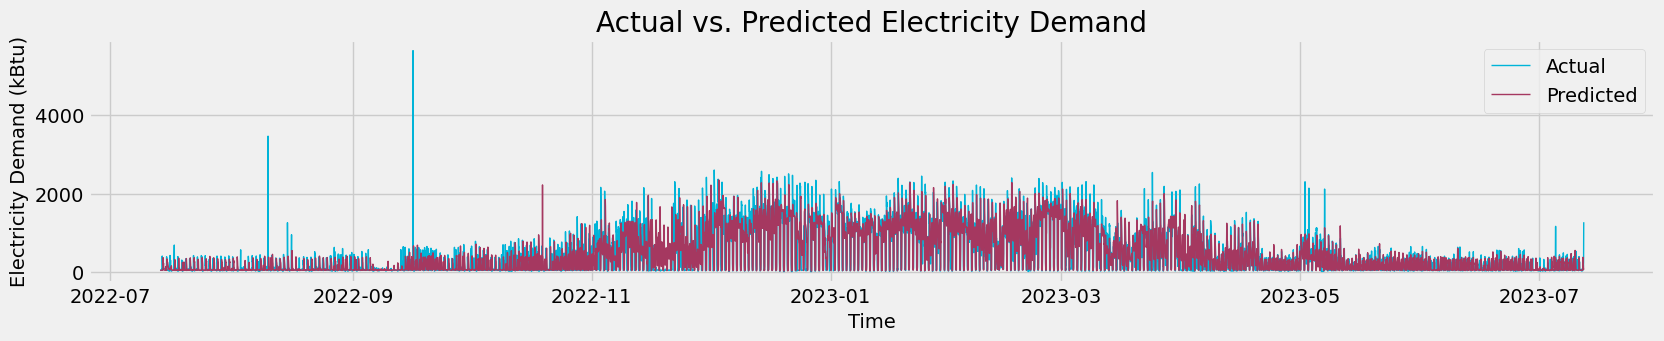

In [27]:

plt.figure(figsize=(18, 3))

#plt.plot(temp.index[-3000:], temp["ARCPavilion_Electricity_Demand_kBtu"].tail(3000), label="Actual", linewidth = 1, color = "#00b4d8")
#plt.plot(temp.index[-3000:], send_df["ARCPavilion_Baseline_Modeled_Electricity"].tail(3000), label="Predicted", linewidth=1, color="#a53860")

plt.plot(temp.index, temp["ARCPavilion_Steam_Demand_kBtu"], label="Actual", linewidth = 1, color = "#00b4d8")
plt.plot(temp.index, send_df["ARCPavilion_Baseline_Modeled_Steam"], label="Predicted", linewidth=1, color="#a53860")

plt.xlabel("Time")
plt.ylabel("Electricity Demand (kBtu)")
plt.title("Actual vs. Predicted Electricity Demand")

plt.legend()

plt.show()


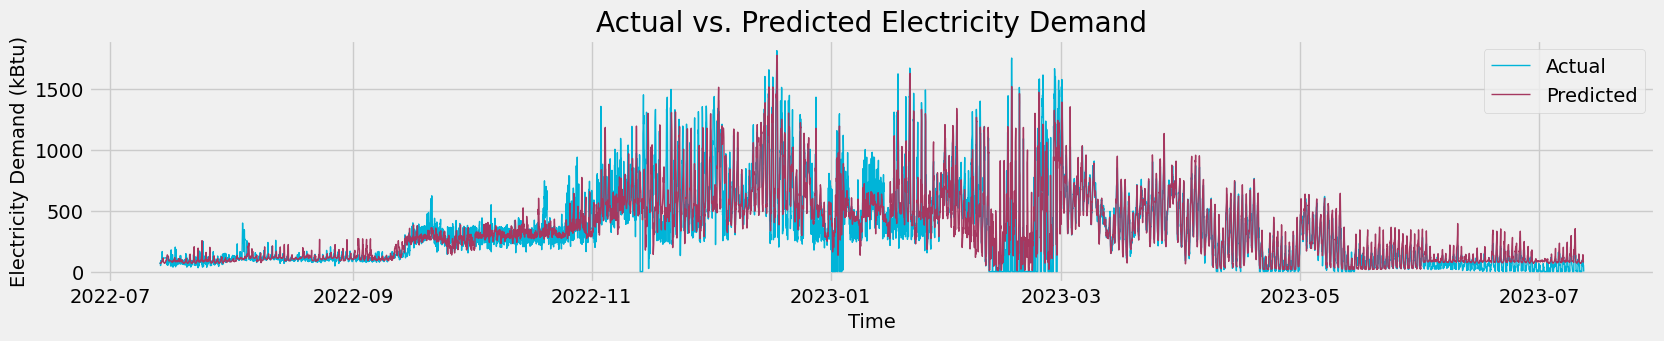

In [28]:
plt.figure(figsize=(18, 3))

#plt.plot(temp.index[-3000:], temp["ARC_Electricity_Demand_kBtu"].tail(3000), label="Actual", linewidth = 1, color = "#00b4d8")
#plt.plot(temp.index[-3000:], send_df["ARC_Baseline_Modeled_Electricity"].tail(3000), label="Predicted", linewidth=1, color="#a53860")

plt.plot(temp.index, temp["Asmundson_Steam_Demand_kBtu"], label="Actual", linewidth = 1, color = "#00b4d8")
plt.plot(temp.index, send_df["Asmundson_Baseline_Modeled_Steam"], label="Predicted", linewidth=1, color="#a53860")

plt.xlabel("Time")
plt.ylabel("Electricity Demand (kBtu)")
plt.title("Actual vs. Predicted Electricity Demand")

plt.legend()

plt.show()

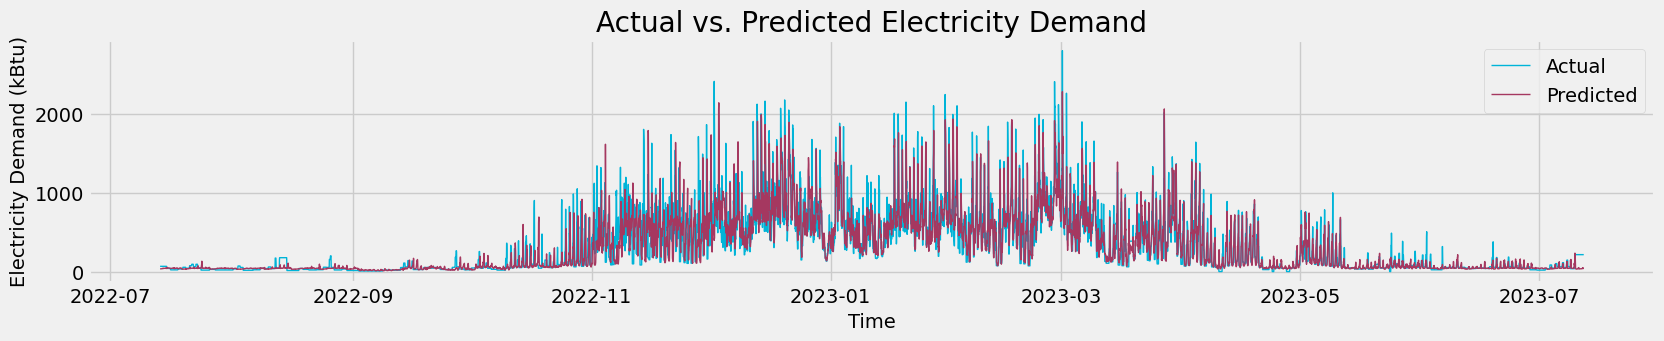

In [29]:
plt.figure(figsize=(18, 3))

plt.plot(temp.index, temp["AcademicSurge_Steam_Demand_kBtu"], label="Actual", linewidth = 1, color = "#00b4d8")
plt.plot(temp.index, send_df["AcademicSurge_Baseline_Modeled_Steam"], label="Predicted", linewidth=1, color="#a53860")

#plt.plot(temp.index[-1080:], temp["AcademicSurge_Electricity_Demand_kBtu"].tail(1080), label="Actual", linewidth = 1, color = "#00b4d8")
#plt.plot(temp.index[-1080:], send_df["AcademicSurge_Baseline_Modeled_Electricity"].tail(1080), label="Predicted", linewidth=1, color="#a53860")

plt.xlabel("Time")
plt.ylabel("Electricity Demand (kBtu)")
plt.title("Actual vs. Predicted Electricity Demand")

plt.legend()

plt.show()

0.05975806029155388
0.8566790851329901


<Figure size 640x480 with 0 Axes>

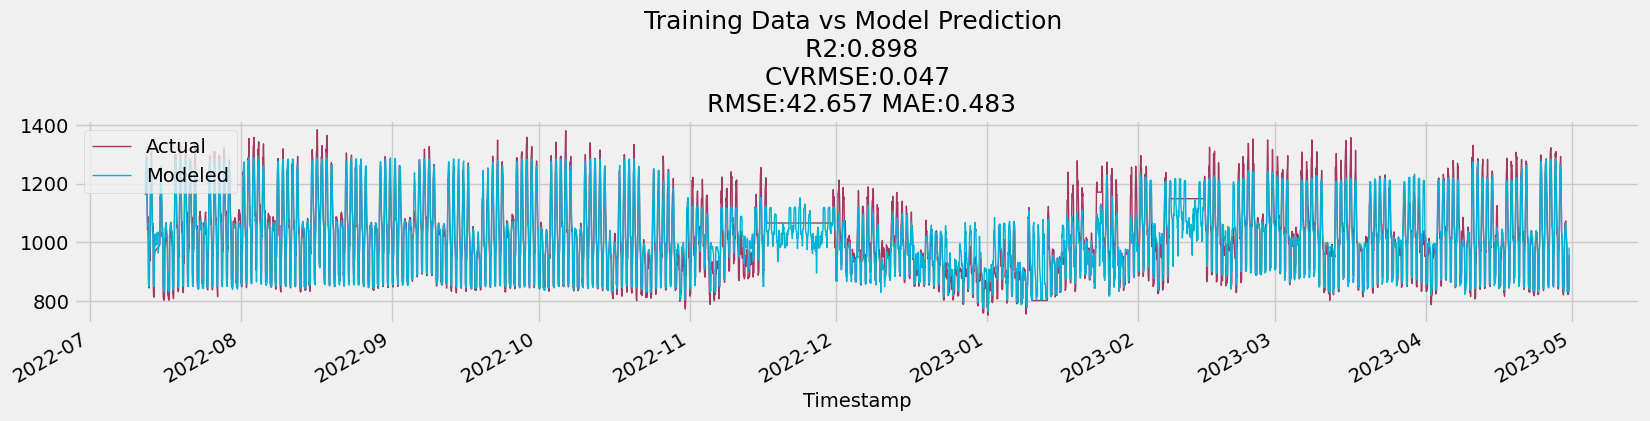

<Figure size 640x480 with 0 Axes>

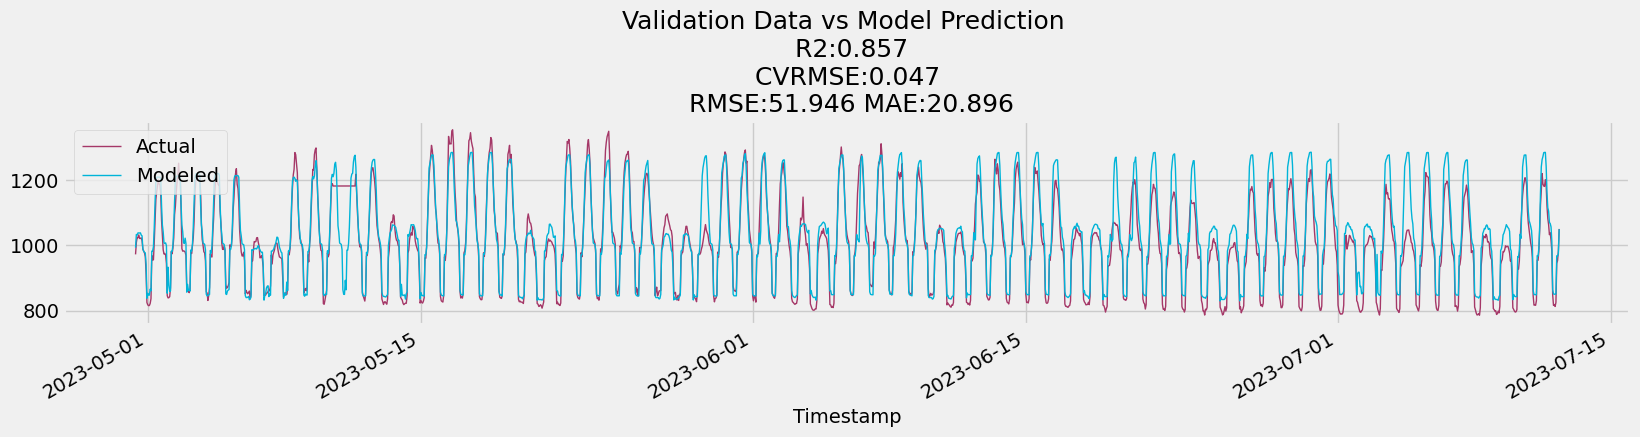

In [47]:
method = gs_gbt
X_train = X_train_scaled
X_val = X_val_scaled
y_train = y_train
y_val= y_val    
    #r2
r2_train = r2_score(y_train, method.predict(X_train))
r2_val = r2_score(y_val, method.predict(X_val))
    #rmse
rmse_train = math.sqrt(mean_squared_error(y_train, method.predict(X_train)))
rmse_val = math.sqrt(mean_squared_error(y_val, method.predict(X_val)))
    #mae
mae_train = np.median((method.predict(X_train) - y_train))
mae_val = np.median(method.predict(X_val) - y_val)
    #cvrmse
cvrmse_train = rmse_train/(np.max(method.predict(X_train))-np.min(method.predict(X_train))/2)
cvrmse_val = rmse_val/(np.max(method.predict(X_val))-np.min((method.predict(X_val))/2))

    #plot of Training Data vs Model Prediction
plt.figure()
training_comparison = pd.DataFrame({"Actual":y_train,
                                    "Modeled":method.predict(X_train)}, index=y_train.index)

training_comparison.sort_index().plot(figsize=(18,3),
                                      title="Training Data vs Model Prediction",
                                      linewidth=1,
                                      color=["#a53860","#00b4d8"])

plt.title(f'Training Data vs Model Prediction \n R2:{round(r2_train,3)}\n CVRMSE:{round(cvrmse_train,3)} \n RMSE:{round(rmse_train,3)} MAE:{round(mae_train,3)}',
          fontsize = 18)
plt.legend(prop={'size': 14},loc='upper left')


    #plot of Validation Data vs Model Prediction
plt.figure()
val_comparison = pd.DataFrame({"Actual":y_val,
                               "Modeled":method.predict(X_val)}, index=y_val.index)
    
    ## set then negative values to 0 only in Validation set.
val_comparison.loc[val_comparison.iloc[:,1]<0] = 0
    
val_comparison.sort_index().plot(figsize=(18,3),
                                 title="Validation Data vs Model Prediction",
                                 linewidth=1,
                                 color= ["#a53868","#00b4d8"])

plt.title(f'Validation Data vs Model Prediction \n R2:{round(r2_val,3)}\n CVRMSE:{round(cvrmse_train,3)} \n RMSE:{round(rmse_val,3)} MAE:{round(mae_val,3)}',
          fontsize = 18)
plt.legend(prop={'size': 14},loc='upper left')    
    
print(cvrmse_val)
print(r2_val)
        # print() 
        # print(round(cvrmse_val,2), round(r2_val,2))
        # print()



In [695]:
pred_start = pd.to_datetime(datetime.now().strftime('%Y-%m-%d %H:00:00')) - timedelta(days=365)
pred_end = datetime.now().strftime('%Y-%m-%d %H:00:00')
calc = "summary"
x_predict = pc.get_stream_by_point('aiTIT4045',  start = pred_start,
                                   end = pred_end, calculation=calc, 
                                   interval=interval, _chunk_size=chunk_size)
x_predict.rename(columns = {'aiTIT4045':'Temp'}, inplace=True)
x_predict['cdd'] = 0
x_predict.loc[x_predict.Temp > 65, 'cdd'] = x_predict.loc[x_predict.Temp > 65, 'Temp'] - 65
x_predict['hdd'] = 0
x_predict.loc[x_predict.Temp < 65, 'hdd'] = 65 - x_predict.loc[x_predict.Temp < 65, 'Temp']
x_predict['cdd2'] = x_predict.cdd**2
x_predict['hdd2'] = x_predict.hdd**2
x_predict["Hour"] = x_predict.index.hour
x_predict["Month"] = x_predict.index.month
x_predict["DOW"] = x_predict.index.dayofweek
x_predict['covid'] = 0
x_predict.loc["2020-03-17":"2021-09-28", 'covid'] = 1
x_predict = x_predict.dropna()
x_predict_scaled = scaler.transform(x_predict)

        # final check
    #     df_check = pc.get_stream_by_point(data_name, start=pred_start, 
    #                                            end=pred_end, calculation=calculation,
    #                                            interval=interval, 
    #                                           _chunk_size=chunk_size)

    #     # checking cvrmse and r2
if cvrmse_val > 0.5:
    pred = np.nan
    pd.DataFrame(pred, index=x_predict.index, columns = [data])

else:
    pred = gs_gbt.predict(x_predict_scaled)

            # plotcheck
    plt.figure()
    #         prediction_comparison = pd.DataFrame({"Actual":df_check[data_name],
    #                                             "Modeled":pred}, index=df_check.index)

    #         prediction_comparison.sort_index().plot(figsize=(18,3),
    #                                               title="Training Data vs Model Prediction",
    #                                               linewidth=1,
    #                                               color=["#a53860","#00b4d8"])

    #         plt.title(f'Acutual Data vs Model Prediction \n R2:{round(r2_val,3)}\n CVRMSE:{round(cvrmse_val,3)}',
    #                   fontsize = 18)
    #         plt.legend(prop={'size': 14},loc='upper left')
    #         #############################
    pd.DataFrame(pred, index=x_predict.index, columns = [data])

14:33:47: Sending API request... Chunk 1 of 1
14:33:49: Response recieved for 1 tags! (1.39)


<Figure size 640x480 with 0 Axes>